In [1]:
!pwd

/home/william/language_modelling_andrej/intro_pytorch/Language_Modelling_intro/notebooks


In [2]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('../../names.txt', 'r').read().splitlines()

In [4]:
len(words)

32034

In [5]:
total_length= 0
for word in words:
    total_length+= len(word)
average_length = total_length/len(words)
average_length

6.122245114565774

# Creating Dataset

In [6]:
unique = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(unique)}
stoi['.'] =0
itos = {i:s for s, i in stoi.items()}
itos;

In [7]:

test_split = int(0.9*len(words))
train_split = int(0.8*len(words))
print(f' {test_split=}, {train_split=}')

 test_split=28830, train_split=25627


In [8]:
# def delete_multiple_element(list_object, indices):
#     indices = sorted(indices, reverse=True)
#     for idx in indices:
#         if idx < len(list_object):
#             list_object.pop(idx)
# def sample_and_remove(list_object, num):
#     #num is number of items to remove
#     original_data= list_object
#     data = list_object
#     sample= random.sample(list(enumerate(data)), num)
#     samples = [s[1] for s in sample]
#     sample_ids= [s[0] for s in sample]
#     delete_multiple_element(data, sample_ids)
#     return samples, data


In [9]:
def train_test_val_split(words):
    
    random.shuffle(words)
    train = words[:train_split]
    val = words[train_split:test_split]
    test= words[test_split:]
    return train, val, test

In [10]:
train, val, test = train_test_val_split(words)

In [11]:
check = all(w in train for w in val) or all(w in train for w in test)
assert check is False

In [12]:
n_gram = 6
def build_dataset(words, n_gram=6):
    X = []
    Y = []
    num =0
    for word in words:
        word = word + '.'
    #     print(word)
        context = [0]* n_gram
        for ch in word:
            num +=1
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(f"{''.join((itos[c] for c in context))} ----> {itos[ix]}")
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
X_train, y_train = build_dataset(train)
X_val, y_val = build_dataset(val)
X_test, y_test = build_dataset(test)


In [13]:
X_train.shape, X_val.shape, X_test.shape

(torch.Size([182599, 6]), torch.Size([22684, 6]), torch.Size([22871, 6]))

In [14]:
y_train.shape, y_val.shape, y_test.shape

(torch.Size([182599]), torch.Size([22684]), torch.Size([22871]))

In [15]:
g = torch.Generator().manual_seed(0)
emb_dim = 15 # embedding dimensions
C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((n_gram*emb_dim, 300),generator=g)* (5/3)/(n_gram*emb_dim)**0.5
b1 = torch.randn(300, generator=g) * 0.1
W2 = torch.randn((300, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

In [16]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [17]:
num_params = 0
for p in parameters:
    num_params += p.nelement()
num_params

35832

In [18]:
loss_history = []
l_rates_e= torch.linspace(-3, -1, 1000)
l_rates = l_rates_e.exp()
l_rates;

In [19]:
batch_size = 64
batch =torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
X_train[batch].shape
# Y[batch];

torch.Size([64, 6])

In [21]:
# for epoch in range(100000):
#     #batch construct
#     batch =torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
#     #forward pass
#     #embedding layer
#     emb = C[X_train[batch]]
#     # emb = emb.view(-1, n_gram*emb_dim)
#     #hidden layer
#     h = torch.tanh((emb.view(-1, n_gram*emb_dim) @ W1) + b1)
#     # h = torch.tanh(h)
#     # output layer
#     logits = (h @ W2) + b2
#     # loss
#     loss = F.cross_entropy(logits, y_train[batch])
#     print(f'{loss=}, {epoch=}')
#     #backward pass
#     for p in parameters:
#         p.grad = None
#     loss.backward()
#     #update parameters
#     lr = 0.075 if epoch < 60000 else 0.001
#     for p in parameters:
#         p.data += lr*p.grad
    
#     #track stats
#     loss_history.append(loss)


In [ ]:
# #loss on train dataset
# emb = C[X_train]
# # emb = emb.view(-1, n_gram*emb_dim)
# #hidden layer
# h = torch.tanh((emb.view(-1, n_gram*emb_dim) @ W1) + b1)
# # h = torch.tanh(h)
# # output layer
# logits = (h @ W2) + b2
# # loss
# loss = F.cross_entropy(logits, y_train)
# loss

In [45]:
# #loss on val dataset
# emb = C[X_val]
# # emb = emb.view(-1, n_gram*emb_dim)
# #hidden layer
# h = torch.tanh((emb.view(-1, n_gram*emb_dim) @ W1) + b1)
# # h = torch.tanh(h)
# # output layer
# logits = (h @ W2) + b2
# # loss
# loss = F.cross_entropy(logits, y_val)
# loss

tensor(2.0521, grad_fn=<NllLossBackward0>)

In [46]:
# #loss on test dataset
# emb = C[X_test]
# # emb = emb.view(-1, n_gram*emb_dim)
# #hidden layer
# h = torch.tanh((emb.view(-1, n_gram*emb_dim) @ W1) + b1)
# # h = torch.tanh(h)
# # output layer
# logits = (h @ W2) + b2
# # loss
# loss = F.cross_entropy(logits, y_test)
# loss

tensor(2.0529, grad_fn=<NllLossBackward0>)

In [52]:
len(loss_history)

120000

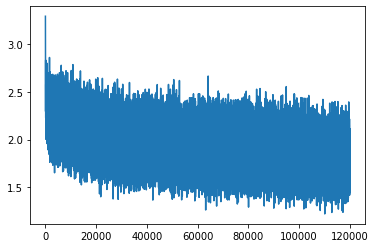

In [51]:
#plotting loss
plt.plot(range(120000), loss_history)

In [1]:
# for _ in range(20):
#     out = []
#     context = [0]*n_gram
#     while True:
#         emb = C[torch.tensor([context])]
#         h = torch.tanh(emb.view(1, -1) @ W1 + b1)
#         logits = h @ W2 + b2
#         probs = F.softmax(logits, dim=1)
#         ix = torch.multinomial(probs, num_samples=1, generator=g).item()
#         context = context[1:] + [ix]
#         out.append(ix)
#         if ix == 0:
#             break
#     print(''.join(itos[i] for i in out))


# Packaging the code into modules

In [22]:
#define linear layers 
class Linear:
    def __init__(self, fan_in, fan_out, bias= True):
        self.fan_in = fan_in 
        self.fan_out = fan_out
        self.weights = torch.randn(self.fan_in, self.fan_out)/fan_in**0.5
        if bias:
            self.bias = torch.randn(self.fan_out)* 0.1
        self.bias = None
            
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        if self.bias:
            return [self.weights , self.bias]
        return [self.weights]
    

In [23]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return None 

In [45]:
class BatchNorm1d:
    def __init__(self,dim, eps= 1e-5, momentum = 0.1, training=True):
        self.eps = eps
        self.momentum = momentum
        self.training = training
        #parameters trained with a backprop
        self.beta = torch.zeros(dim)
        self.gamma = torch.ones(dim)
        #parameters optimized by momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim =True)
            xvar=  x.var(0, keepdim=True)
        else:
            xmean= self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps)
        self.out = xhat * self.gamma + self.beta
        return self.out 
        
        # update running stats
        with torch.no_grad():
            self.running_mean= (1-self.momentum)*self.running_mean + self.momentum*xmean
            self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
    def parameters(self):
        return [self.gamma, self.beta]
            

In [46]:
# initialization
emb_size =  15  # embedding dimensions
vocab_size = 27 # number of unique characters in the alphabet  + '.'
n_gram = 6 #number of characters to consider
hidden_nuerons= 100
C = torch.randn((vocab_size, emb_size))
layers = [
    Linear(n_gram*emb_size, hidden_nuerons, bias=False), BatchNorm1d(hidden_nuerons), Tanh(),
    Linear(hidden_nuerons, hidden_nuerons, bias=False), BatchNorm1d(hidden_nuerons), Tanh(),
    Linear(hidden_nuerons, vocab_size, bias= False), BatchNorm1d(vocab_size),
]


In [47]:
with torch.no_grad():
    #make last layer less confident
    layers[-1].gamma*0.1
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weights *= 5/3
parameters_dict= {}
parameters_dict['C'] = C
parameters = [C]
num_params = 0
for i, layer in enumerate(layers):
#     print(layer.__class__.__name__)
    if layer.parameters():
        name = f'{layer.__class__.__name__} {i}'
        parameters_dict[name] = layer.parameters()
        for p in layer.parameters():
            num_params += p.nelement()
#             print(p.shape)
            parameters += [p]
# set requires grad to true
for p in parameters:
    p.requires_grad =True
num_params

22154

In [ ]:
# fitting the layers
max_steps = 100000
loss_history = []
for step in range(max_steps):
    #batch construct
    batch =torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    #forward pass
    #embedding layer
    emb = C[X_train[batch]]
    x= emb.view(-1, n_gram*emb_dim)
    #layers
    for layer in layers:
        x= layer(x)
    loss= F.cross_entropy(x, y_train[batch])
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.075 if epoch < 60000 else 0.001
    for p in parameters:
        p.data += -lr*p.grad
    
    #track stats
    if step % 1000== 0:
        print(f'{step:2d}/ {max_steps:2d} and loss is {loss.item()}')
    
    loss_history.append(loss)

In [164]:
# Running inference on dataset

for _ in range(20):
    out = []
    context = [0]*n_gram
    while True:
        emb = C[X_train[batch]]
        x= emb.view(-1, n_gram*emb_dim)
        for layer in layers:
            x= layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


tensor([ 0,  0,  0,  0,  0, 10])